## Multiclass Text Classification on Consumer Complaints for Financial Products with Multinomial Naive Bayes and XGBoost
#### Author: Georgios Spyrou (georgios.spyrou1@gmail.com)
#### Completion Date: 26/09/2021

#### Machine Learning Engineer Nanodegree Program - Capstone Project

## Sections

<a id='Introduction'></a>
## Introduction

The data used in this project contain complaints that have been made by consumers regarding financial services and products (e.g. student loans, credit reports, mortgage, etc) in the United States between November 2011 and May 2019. Each of the complaints is marked to belong under one Product Category. This makes the data ideal for supervised learning purposes, with the text (complaint from the consumer) as the **input**, and the category that the complaint belongs to as the **target** variable.

Predicting the correct category that a complaint belongs to can be very beneficial for the financial institutions (companies) that have to deal with responding to hundreds of complaints per day. If the customer who is filling the complaint does not submit it under the correct category, then that becomes a cost for the financial institution as -usually- they will have to:

   1) Identify that a complaint is under the wrong category in the first place, which is something that happens only after someone has already spent time with the case. <br>
   2) Re-classify and redirect the complaint to the correct category and the appropriate personnel for further examination. 

Therefore, it's straighforward to understand the importance of an automated system that can identify the complaint category by looking at the compaint itself (input from the client), and automatically forward the case to the team responsible for this "group" of complaints. In this project, we will attempt to create models that could offer the above functionality and evaluate their performance, so that we can answer the question: _Would it worth it for a company to integrate a system like this into their main processes ?_

The dataset for this project is publicly available and it's getting updated daily from the USA Consumer Financial Protection Bureau. The latest version can be found <a href="https://catalog.data.gov/dataset/consumer-complaint-database" style="text-decoration: none"> here</a>.

After this quick introduction, we can move to the main part of the project. At the beggining we will load the dataset, perform any necessary data cleaning operations and continue with the exploratory data analysis part, so that we can get a better understanding of the dataset. Afterwards, we will make sure that we understand the data (EDA) and we will proceed to the modeling part where we are going to create different types of classification algorithms and compare their performance on predicting the category to which each complaint should fall into.

<a id='Data_Loading'></a>
## Part 1 - Data Retrieval

We can start by importing the necessary python packages, setup the project directory and load the dataset so we can get a better understanding of the data format.

In [21]:
!pip install wget

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [22]:
import os
import wget
import nltk
import json
import zipfile
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [23]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
project_dir = os.getcwd()
print("The project directory is '{0}'".format(project_dir))

The project directory is '/home/ec2-user/SageMaker/Capstone'


Now that we have created and setup a project directory, we can move ahead and retrieve the data from the main source. We can find the relevant information regarding the URL from which we will use to retrieve the data, as well as the output folder name (local) inside the 'config.json' file. This file will be used throughout the project to save configuration information.

In [25]:
!pygmentize config.json

{
    "input_data": 
    {
        "source_url": "https://files.consumerfinance.gov/ccdb/complaints.csv.zip",
        "output_directory": "data"
    }
        
}


In [26]:
json_file_path = project_dir / Path('config.json')

with open(json_file_path, 'r') as json_file:
    config = json.load(json_file)
json_file.close()

In [27]:
data_out_path = project_dir / Path(config['input_data']['output_directory'])

if not os.path.exists(data_out_path):
    os.makedirs(data_out_path)

At this point we have created a local folder that where we are going to save the initial dataset retrieved directly from the source. In the following cell, we will use the <em>source_url</em> to get the .zip file and decompress the dataset to the specified output folder. Afterwards, we are going to delete the zipped file to save memory.

In [28]:
full_data_csv_name = 'complaints.csv'

In [9]:
if not os.path.isfile(os.path.join(data_out_path, full_data_csv_name)):
    zip_filename = wget.download(url=config['input_data']['source_url'], out=str(data_out_path))

    with zipfile.ZipFile(zip_filename, 'r') as zipf:
        print("Extracting files from {0} to {1}\n".format(zip_filename, data_out_path))
        zipf.extractall(data_out_path)
    
    print("Removing file {0} ...".format(zip_filename))
    os.remove(zip_filename)    

Extracting files from /home/ec2-user/SageMaker/Capstone/data/complaints.csv.zip to /home/ec2-user/SageMaker/Capstone/data

Removing file /home/ec2-user/SageMaker/Capstone/data/complaints.csv.zip ...


<a id='Reducing_Data'> <a/>
#### Reducing the dataset size

The full dataset has been downloaded and saved in our local environement. By taking a look at it we can infer that it's quite big in size (close to 1.5GB and it keeps growing daily) something that can potentially be an issue given the resources available in the AWS instances used in this project. To face this issue we are going to use a _subset_ of the initial dataset. Specifically, even though the dataset contains data from 2011 up to 2021, we are going to work with a subset of the dataset that is covering the range **'2019-01-01' to '2020-12-31'**, i.e. two full years worth of data. This is also helpful as it's limiting the amount of different product categories that we will have to classify the complaints, as in later years more and more categories added to the dataset - something that could potentially make our analysis cumbersome.

In [10]:
csv_file_path = os.path.join(data_out_path, full_data_csv_name)
csv_file_path

'/home/ec2-user/SageMaker/Capstone/data/complaints.csv'

In [11]:
complaints_df = pd.read_csv(csv_file_path)

In [12]:
complaints_df.shape

(2304681, 18)

In [13]:
complaints_df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [14]:
complaints_df['Date received'] = pd.to_datetime(complaints_df['Date received'])

In [15]:
# Get the year that the complaint took place as a separate column
complaints_df['Year'] = complaints_df['Date received'].apply(lambda date: date.year)

In [17]:
def plot_num_observations_per_category(
    df: pd.DataFrame, col: str,
    by_year=True,
    figsize=(10,8)
) -> None:
    """ Returns a countplot with the number of observations
    based on the column defined by 'col'
    """
    hue = None
    if by_year == True:
        hue = df['Year']
    plt.figure(figsize=figsize)
    sns.countplot(y=df[col], hue=hue,order=df[col].value_counts().index)
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.title(f'Number of Complaints per {col}', fontweight="bold")
    plt.grid(True, alpha=0.2, color='black')
    plt.show()

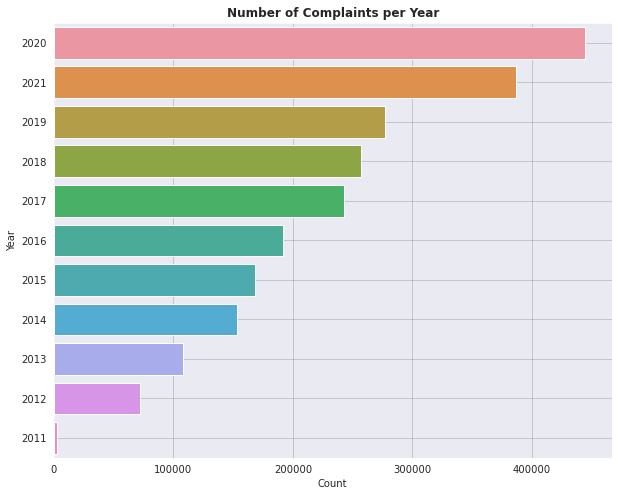

In [17]:
plot_num_observations_per_category(df=complaints_df, col='Year', by_year=False)

In [18]:
def subset_dataframe_on_date_column(
    df: pd.DataFrame,
    date_col: str,
    min_date: str,
    max_date: str
) -> pd.DataFrame:
    reduced_df = df[(df[date_col] >= min_date) & (df[date_col] <= max_date)]
    return reduced_df

In [19]:
# Subset the dataset to 2 years
complaints_df = subset_dataframe_on_date_column(
    df=complaints_df,
    date_col='Date received', 
    min_date='2019-01-01',
    max_date='2020-12-31'
    )

At first we can have a look at the distribution of complaints from the full dataset, compared to the category that they belong:

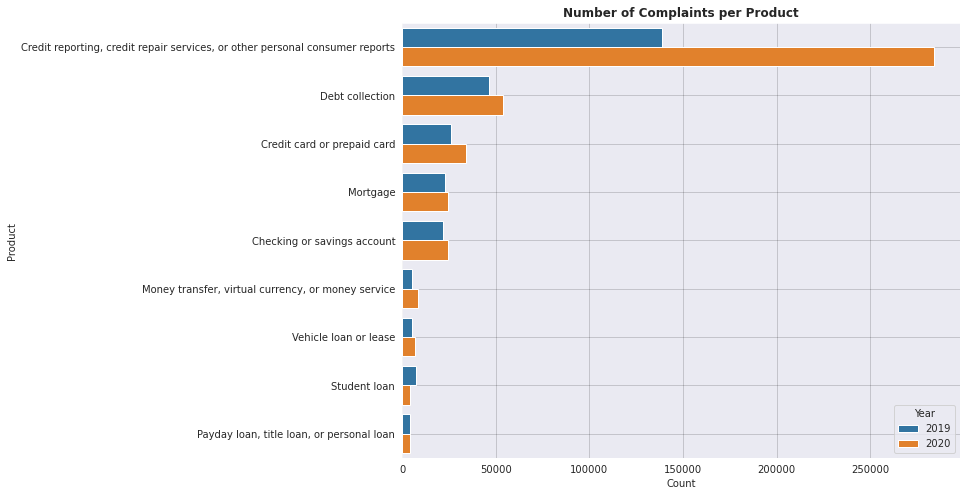

In [20]:
plot_num_observations_per_category(df=complaints_df, col='Product', by_year=True)

Above we can see that after reducing the dataset to data only from 2019 and 2020, we end up with 9 distinct Product categories. Moreover, its obvious that we have some class imbalance in the dataset as the first category (Credit reporting) seems to be dominating the data compared to the rest of the categories across all the years of interest.

Now should also take into consideration the fact that our main column of interest - which contains the complaint from the consumer - is the 'Consumer complaint narrative', which we will rename to just 'Complaint' for an easy of use.

In [21]:
complaints_df.rename(columns={'Consumer complaint narrative': 'Complaint'}, inplace=True)

In [22]:
col_to_reduce_on = 'Credit reporting, credit repair services, or other personal consumer reports'

Moreover, we are going to further reduce the dataset by randomly selecting 60% of the observations. Additionaly, we are going to tackle the product category imbalance issue by further undersampling rows _only_ from the 'Credit reporting, credit repair services, or other personal consumer reports' category and for the year 2020, which is dominating the dataset.

In [23]:
complaints_df = complaints_df.drop(complaints_df[complaints_df['Product'] == col_to_reduce_on].sample(frac=.60).index)

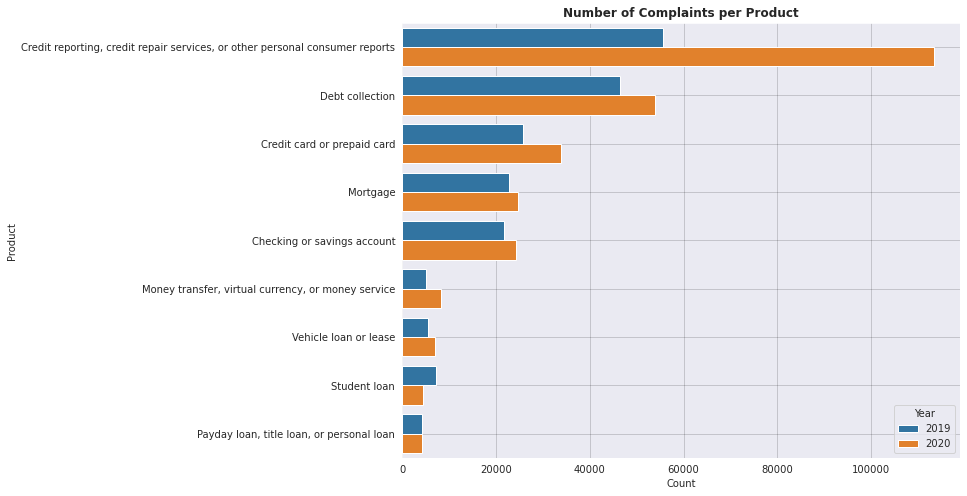

In [24]:
plot_num_observations_per_category(df=complaints_df, col='Product', by_year=True)

In [25]:
complaints_df = complaints_df.drop(complaints_df[(complaints_df['Product'] == col_to_reduce_on) & (complaints_df['Year'] == 2020)].sample(frac=.60).index)

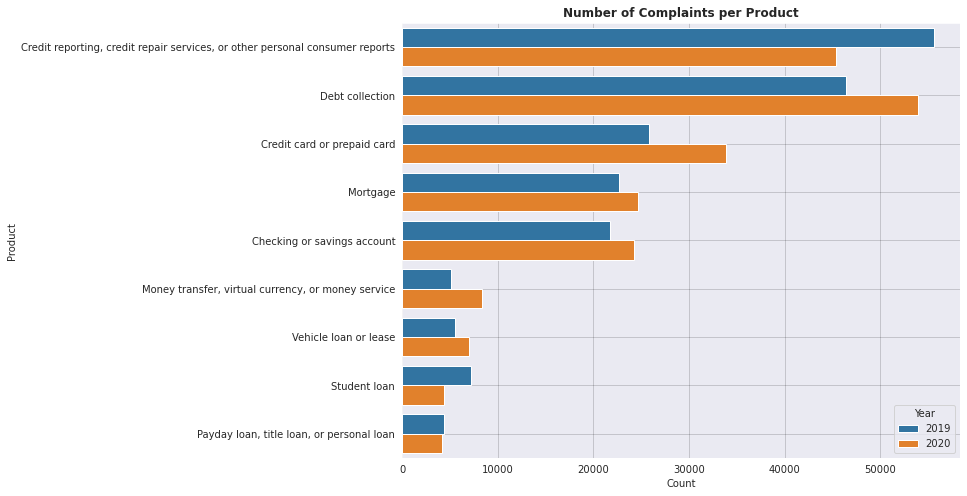

In [26]:
plot_num_observations_per_category(df=complaints_df, col='Product', by_year=True)

Above we can see that even though there is still some class imbalance, the dataset is in a better shape than the original view.

Now, we need to check if we have rows for which this column is empty. That would indicate that these rows are not very relevant for our analysis as they won't provide any useful input in our models later in the project.

In [27]:
def get_empty_rownumber_for_col(df: pd.DataFrame, col_name: str) -> None:
    num_empty_rows_col = df.isnull().sum()[col_name]
    percnt = 100 * np.round(num_empty_rows_col/df.shape[0], 4)
    print(
        "There are {0} out of {1} rows that are empty for {2} ({3}%)". format(num_empty_rows_col, df.shape[0], col_name, percnt)
    )
    return num_empty_rows_col

In [28]:
_ = get_empty_rownumber_for_col(df=complaints_df, col_name='Complaint')

There are 216502 out of 400294 rows that are empty for Complaint (54.09%)


And we can filter the dataset to retain only the rows for which the 'Complaing' column is populated

In [29]:
complaints_df = complaints_df[complaints_df['Complaint'].notnull()]
complaints_df.shape

(183792, 19)

In [30]:
_ = get_empty_rownumber_for_col(df=complaints_df, col_name='Complaint')

There are 0 out of 183792 rows that are empty for Complaint (0.0%)


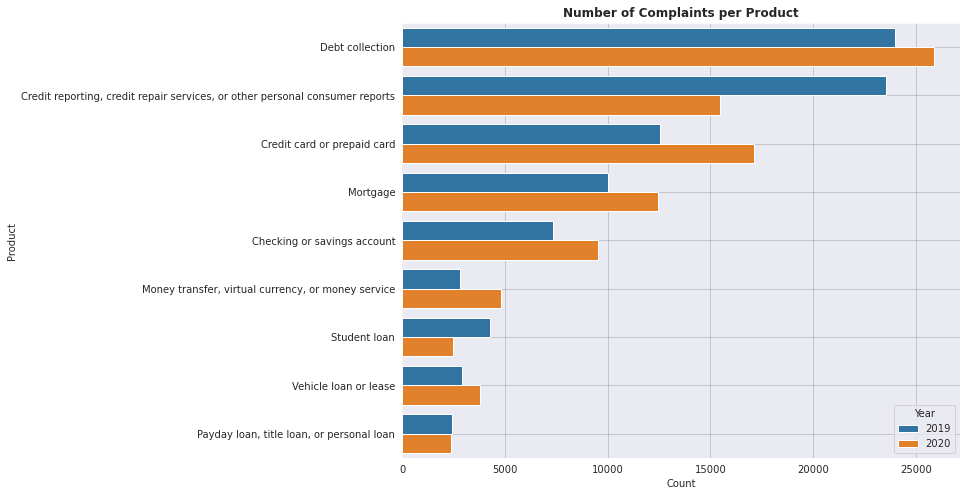

In [31]:
plot_num_observations_per_category(df=complaints_df, col='Product', by_year=True)

Moreover, the initial dataset has many columns that are not going to be used throughout the project. Hence, we can exclude them from the main dataframe, so that we free up some space at the creationg of the final CSV file.

In [32]:
list(complaints_df.columns)

['Date received',
 'Product',
 'Sub-product',
 'Issue',
 'Sub-issue',
 'Complaint',
 'Company public response',
 'Company',
 'State',
 'ZIP code',
 'Tags',
 'Consumer consent provided?',
 'Submitted via',
 'Date sent to company',
 'Company response to consumer',
 'Timely response?',
 'Consumer disputed?',
 'Complaint ID',
 'Year']

In [33]:
cols_to_retain = ['Complaint ID', 'Year', 'Complaint', 'Product', 'Company', 'State']

In [34]:
complaints_df = complaints_df[cols_to_retain]

In [35]:
complaints_df.head(2)

,Complaint ID,Year,Complaint,Product,Company,State
1,3425257,2019,I contacted Ally on Friday XX/XX/XXXX after fa...,Vehicle loan or lease,ALLY FINANCIAL INC.,NJ
7,3571591,2020,I got a loan for {$500.00} in late XXXX with h...,"Payday loan, title loan, or personal loan","ACIMA CREDIT, LLC",GA


Our final step to reduce the size of the data will be to reduce the amount of characters that each review can have.


In [36]:
complaints_df['Complaint_Length'] = complaints_df['Complaint'].apply(lambda x: len(x.split()))

In [37]:
complaints_df['Complaint_Length'].describe()

count    183792.000000
mean        209.753259
std         253.151097
min           1.000000
25%          73.000000
50%         139.000000
75%         255.000000
max        6014.000000
Name: Complaint_Length, dtype: float64

In [38]:
complaints_df.drop(columns='Complaint_Length', inplace=True)

As we can see there are 75% of the complaints that they have over 255 words used in the complaint. Hence, we are going to set a limit around the mean (i.e. 100 words) and reduce the size of the complaint text to this amount.

In [39]:
def pad_sentence_on_words(
    sentence: 'str',
    how='right',
    words_to_retain:int = 100
) -> 'str':
    if how == 'right':
        reducted_sentence = ' '.join(sentence.split()[0: words_to_retain])
    else:
        reducted_sentence = ' '.join(sentence.split()[words_to_retain::])
    return reducted_sentence

In [40]:
complaints_df['Complaint'] = complaints_df['Complaint'].apply(lambda x: pad_sentence_on_words(x))

In [41]:
complaints_df['Complaint_Length'] = complaints_df['Complaint'].apply(lambda x: len(x.split()))

Text(0.5, 0, 'Number of words')

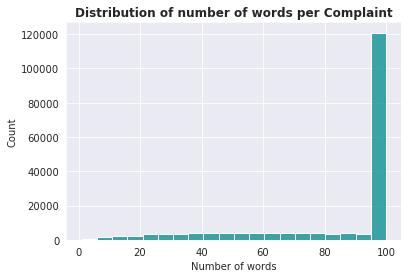

In [57]:
sns.histplot(complaints_df['Complaint_Length'].values, bins=20, color='darkcyan')
plt.title('Distribution of number of words per Complaint', fontweight='bold')
plt.xlabel('Number of words')

Hence, after performing this operation we end up with the distribution as shown in Figure 7, where we can observe that most of the complaints in the dataset used to exceed 100 words - and now they contain exactly 100 words.

Now that we have the final "raw_format" of our dataset, we will need to replace the initial .csv file with a new one that contains only the reduced data. That way we will save space and make loading, as well as processing, the data faster and easier.

<a id='Final_Input_Data'> </a>

In [58]:
complaints_df.drop(columns='Complaint_Length', inplace=True)

In [29]:
reduced_csv_filename = 'complaints_reduced.csv'
reduced_csv_filepath = os.path.join(data_out_path, reduced_csv_filename)

In [60]:
complaints_df.to_csv(reduced_csv_filepath, index=False)

In [61]:
# Deleting the initial CSV file to empty space in the EC2 instance where the SageMaker notebook is running
os.remove(os.path.join(data_out_path, full_data_csv_name))

In [62]:
os.listdir('data')

['xgboost_output',
 'mnb_output',
 '.ipynb_checkpoints',
 'complaints_reduced.csv']

In [30]:
complaints_df = pd.read_csv(reduced_csv_filepath, index_col=None)

print('\nThe final dataset has {0} rows and {1} columns\n'.format(complaints_df.shape[0], complaints_df.shape[1]))

complaints_df.head(5)


The final dataset has 183792 rows and 6 columns



,Complaint ID,Year,Complaint,Product,Company,State
0,3425257,2019,I contacted Ally on Friday XX/XX/XXXX after fa...,Vehicle loan or lease,ALLY FINANCIAL INC.,NJ
1,3571591,2020,I got a loan for {$500.00} in late XXXX with h...,"Payday loan, title loan, or personal loan","ACIMA CREDIT, LLC",GA
2,3294745,2019,Two accounts are still on my credit history af...,"Credit reporting, credit repair services, or o...",Experian Information Solutions Inc.,FL
3,3265029,2019,I have a bank of America small business credit...,Credit card or prepaid card,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA
4,3341310,2019,I opened a citi double cash card the beginning...,Credit card or prepaid card,"CITIBANK, N.A.",FL


<a id='data_cleaning_eda'></a>
## Part 2 - Exploratory Data Analysis (EDA) & Data Cleaning

In this part we are going to use the final form of the data from Part 1, and we will dive into the details of the dataset. Specifically, we are going to get get a better understand of the features by using visualizations, as well as identify interesting summaries. This process will help us, except understanding the dataset better, to identify any potential issues with the data that would be hard to notice otherwise.

In [31]:
def plot_top_complaints(df: pd.DataFrame, agg_col: str, top_n: int, bottom=False, rot=45, figsize=(10,8)):
    """ Aggregate a dataframe based on column of interest and calculate the number of
    observations per aggregated group. The function returns a barplot object showing the results 
    of the above calculation.

    Parameters:
    ----
    agg_col: Name of the column to perform aggregation
    top_n: Amount of observations to be included in the plot
    bottom: Plot the top-n from the top (highest) or from the bottom (lowest)
    """
    size = float(df.shape[0])    
    rot = rot

    try:
        most_cmplts = df[['Complaint ID', agg_col]].groupby([agg_col]).agg(['count'])
    
        most_cmplts = most_cmplts.sort_values(
                by=[('Complaint ID','count')],
                ascending=bottom
                )

        plt.figure(figsize=figsize)
        
        ax = sns.barplot(
            x=most_cmplts.index[0:top_n],
            y=('Complaint ID', 'count'),
            data=most_cmplts[0:top_n]
            )
            
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2., height + 4,
                    '{:1.2f}%'.format(100 * height/size), ha="center")

        ax.set_xticklabels(ax.get_xticklabels(), rotation=rot)
        plt.ylabel('Number of complaints', fontweight='bold')
        plt.title(f'{agg_col} with the most number of complaints',
                  fontweight='bold')
        plt.grid(True, alpha=0.2, color='black')
        plt.show()
    except KeyError:
        print('agg_col does not correspond to a column that exists')

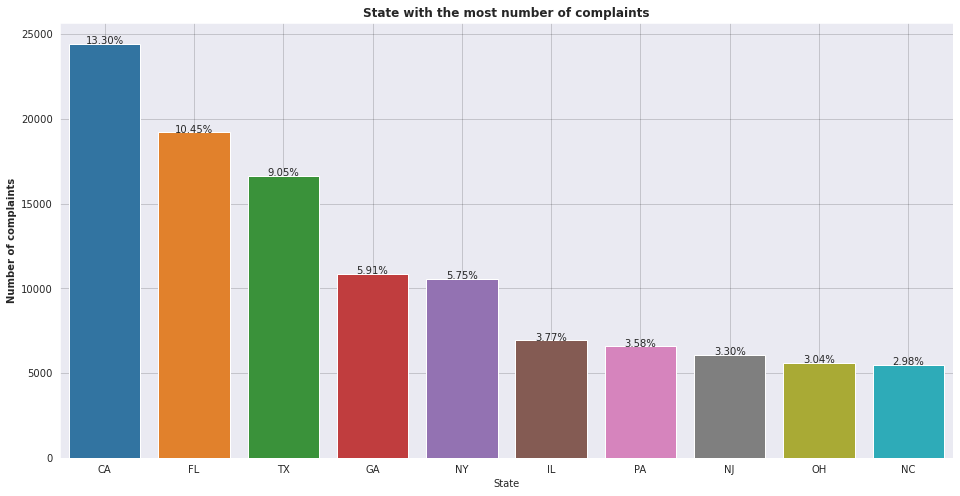

In [32]:
plot_top_complaints(df=complaints_df,
                    agg_col='State',
                    top_n=10,
                    bottom=False,
                    rot=0,
                    figsize=(16,8)
                    )

We can see that only 5 States (California, Florida, Texas, Georgia and New York) account for more that 40% of the total complaints.

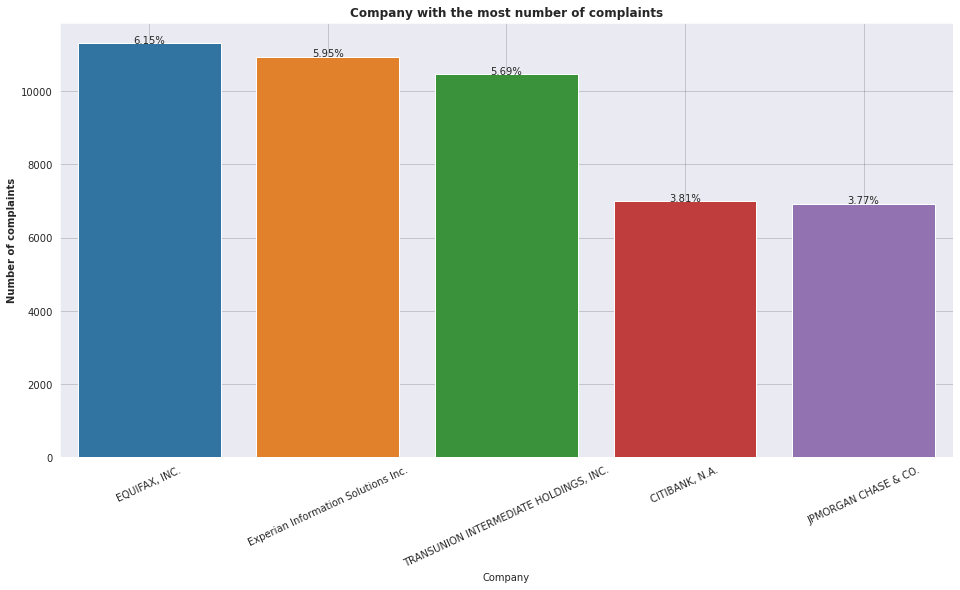

In [33]:
plot_top_complaints(df=complaints_df,
                    agg_col='Company',
                    top_n=5,
                    bottom=False,
                    rot=25,
                    figsize=(16,8)
                    )

Similarly, the first 5 Companies presented above seem to receive around 25% of the overall amount of complaints.

Now, as we saw earlier in the project the current dataset contains 9 categories for the _Product_, but some of these categories appear to be about overlapping issues. Therefore we will merge such cases of categories that are overlapping, and we will end up with 7 Categories instead of 9 that were present in the reduced dataset. The categories that are getting merged into another broader group, can be found below:

In [34]:
product_category_mapping = {
    'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting',    
    'Debt collection': 'Debt collection',                                                                  
    'Credit card or prepaid card': 'Credit/prepaid card',                                                     
    'Mortgage': 'Mortgage',                                                                        
    'Checking or savings account': 'Checking/savings account',                                                      
    'Student loan': 'Loans',                                                                     
    'Money transfer, virtual currency, or money service': 'Money services',                               
    'Vehicle loan or lease': 'Loans',                                                           
    'Payday loan, title loan, or personal loan': 'Loans'
    }

In [35]:
complaints_processed_df = complaints_df.copy()

complaints_processed_df['Product'].replace(product_category_mapping, inplace=True)

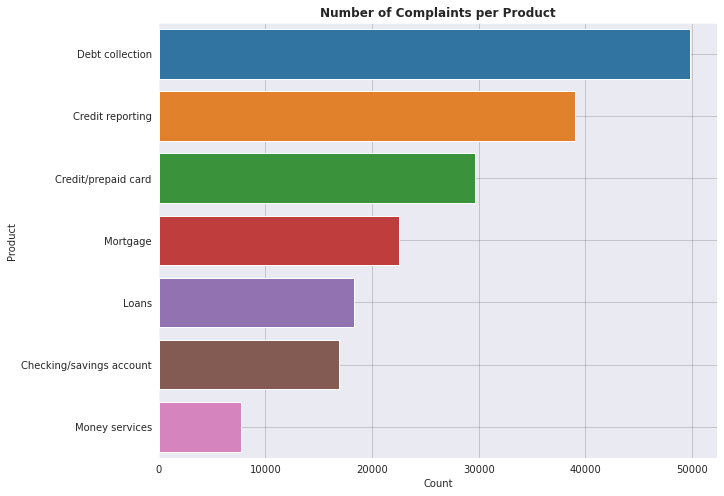

In [36]:
plot_num_observations_per_category(df=complaints_processed_df, col='Product', by_year=False)

In [37]:
def plot_donut_num_observations(
    input_df: pd.DataFrame,
    col='Product',
    figsize=(6, 6)
) -> None:
    vals = input_df[col].value_counts()
    groups = input_df[col].value_counts().index.tolist()
    
    filtered_df = pd.DataFrame({'Num_Reviews': vals, 'group': groups})
    
    colors_ls = ["tab:orange", "tab:purple", "tab:green", "tab:red", "tab:cyan", "tab:olive", "tab:brown"]
    
    plt.figure(figsize=(figsize))
    plt.subplot(1, 2, 2)
    
    cen_circle = plt.Circle((0, 0), 0.6, color='white')
    
    plt.pie(filtered_df['Num_Reviews'],
            labels= filtered_df['group'],
            autopct='%1.1f%%',
            pctdistance = 1.32,
            startangle=18,
            labeldistance=1.06,
            colors=colors_ls)
    plt.axis('equal')
    plt.gca().add_artist(cen_circle)
    plt.show()

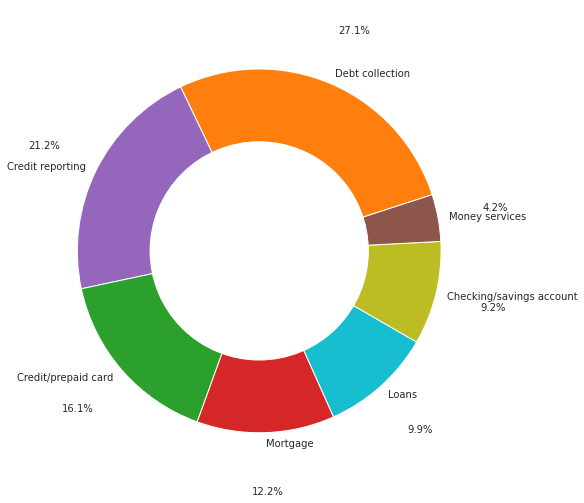

In [38]:
plot_donut_num_observations(input_df=complaints_processed_df, figsize=(16,9))

In the above graph we can see that - even after merging our data and constructing the final 7 Product categories - the 'Credit Reporting' and 'Debt Collection' categories seem to be dominating the dataset as they account for almost 49% of the complaints. The class imbalance is a significant factor in our data, as further in the project we should be careful of how we construct the prediction models, as well as the type of evaluation metrics that we are going to use to assess their performance.

<a id='data_preprocessing'> </a>
## Part 3 - Data Preprocessing

Before creating the classifiers in order to predict the Product category that a specific complaint should fall into, we will have to deal with the fact the the input to our algorithms (Complaint) has a text format. 

At first, we will perform the regular text cleaning operations that you are likely to see in any Natural Language Processing project. This includes the creation of tokens (i.e. split each complaint into separate words) and the removal of stopwords, punctuation and numbers from the text, as this information does not offer much into predicting the correct Product category. Finally, we will perform a lemmatization task with which we will convert the words to their base form.

For the rest of the project we will continue with a subset of the already reduced dataset. Specifically, we will create a new dataframe which will contain only the Complaing and the respective Product category that the complaint belongs to.

In [39]:
relevant_cols = ['Complaint', 'Product']

complaints_df = complaints_processed_df[relevant_cols]

In [40]:
del complaints_processed_df

In [41]:
import string
from typing import List
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [42]:
punct_ls = list(string.punctuation)
punct_ls.extend([2*x for x in list(string.punctuation)])
punct_ls.extend([3*x for x in list(string.punctuation)])

In [43]:
def remove_stopwords(text: List['str'], stpwds_ls: List['str']) -> List['str']:
    return [token for token in text if token not in stpwds_ls]


def remove_punctuation(text: List['str'], punct_ls: List['str']) -> List['str']:
    return [token for token in text if token not in punct_ls]


def remove_numbers(text: List['str']) -> List['str']:
    return [token for token in text if not token.isdigit()]


def remove_whitespace(text: List['str']) -> List['str']:
    return [token for token in text if token != ' ']

In [44]:
def tokenize_and_clean(
    text: str,
    stopwords_ls: List[str],
    stopwords=True,
    punct=True,
    numerics=True
) -> List[str]:
    """ Performs tokenizations and cleaning processes given a document/text.
    The function will always tokenize the given text but the cleaning tasks
    are optional.
    
    Parameters
    ----------
    text: 
        A document, which can be a word or sentence of arbitrary length.
    stopwords: default True
        Indicator of removing tokens that are stopwords.
    punct: 
        Indicator of removing tokens that are punctuation marks.
    numerics: 
        Indicator of removing tokens that correspond to numbers.
    Returns
    --------
         A tokenized version of 'text' with the necessary updates depending on
         the cleanup steps performed.
    """
    tokenized = nltk.word_tokenize(text, language='english')
    
    tokenized = [token.lower() for token in tokenized]
    
    tokenized = remove_whitespace(tokenized)

    if punct:
        tokenized = remove_punctuation(tokenized, punct_ls=punct_ls)
        
    if numerics:
        tokenized = remove_numbers(tokenized)
        
    if stopwords:
        tokenized = remove_stopwords(tokenized, stpwds_ls=stopwords_ls)

    return tokenized

In [45]:
classified_tokens = ['xxxx', 'xx', 'xx/xx/xxxx'] # Used to exclude info that was classified in the complaint

stop_words = list(set(stopwords.words('english')))
stop_words.extend(classified_tokens)

In [46]:
stop_words[0:5]

['me', 'been', 'is', 'an', "mightn't"]

Now that we have imported any required libraries and created the main function that will be used to clean up the complaints text, we can start the data preprocessing part.
<a id="tokenization"> </a>
<br><br>
**a. Tokenizing the Complaints and removing stopwords/numbers/classified information**

In [47]:
complaints_df['Complaint_Tokenized'] = complaints_df.apply(
    lambda x: tokenize_and_clean(x['Complaint'], stopwords_ls=stop_words),
    axis=1
    )

<a id="lemmatize"> </a>
**b. Performing lemmatization to the complaints**

In [48]:
def lemmatize(text: List['str'], pos_type = 'a') -> List['str']:
    return [lemmatizer.lemmatize(token, pos=pos_type) for token in text]

In [49]:
res = lemmatize(tokenize_and_clean('Hello  apples played how are you ?', stopwords_ls=stop_words), pos_type='v')

assert res == ['hello', 'apples', 'play']

In [50]:
complaints_df['Complaint_Lemmatized'] = complaints_df.apply(
    lambda x: lemmatize(x['Complaint_Tokenized'], pos_type='v'), 
    axis=1
    )

In [51]:
complaints_df['Complaint_Lemmatized'] = complaints_df.apply(
    lambda x: lemmatize(x['Complaint_Lemmatized'], pos_type='n'), 
    axis=1
    )

<a id="sentence_lemma_tokens"> </a>
**c. Join the processed tokens back to a single sentence/review**

In [52]:
def wordlist_to_sentence(word_ls: List[str]) -> 'str':
    return ' '.join([word for word in word_ls])

In [53]:
complaints_df['Complaint_Sentence'] = complaints_df.apply(
    lambda x: wordlist_to_sentence(x['Complaint_Lemmatized']), 
    axis=1
    )

Now that we have completed the text preprocessing part, we are going to save the output dataframe as a .pkl file, as re-running the processing each time it would be very time consuming.

In [54]:
# Pickle the dataframe so reprocessing is not necessary every time
pickled_df_filename = 'complaints_processed.pkl'
pickled_file_loc = project_dir / Path(config['input_data']['output_directory']) / pickled_df_filename
print(pickled_file_loc)

/home/ec2-user/SageMaker/Capstone/data/complaints_processed.pkl


In [55]:
# df to pickle
complaints_df.to_pickle(pickled_file_loc)

In [56]:
del complaints_df

In [57]:
# pickled file to df
complaints_df = pd.read_pickle(pickled_file_loc)

In [58]:
complaints_df.head(10)

,Complaint,Product,Complaint_Tokenized,Complaint_Lemmatized,Complaint_Sentence
0,I contacted Ally on Friday XX/XX/XXXX after fa...,Loans,"[contacted, ally, friday, falling, behind, pay...","[contact, ally, friday, fall, behind, payment,...",contact ally friday fall behind payment due wo...
1,I got a loan for {$500.00} in late XXXX with h...,Loans,"[got, loan, 500.00, late, http, owner, let, sp...","[get, loan, 500.00, late, http, owner, let, sp...",get loan 500.00 late http owner let spend 250....
2,Two accounts are still on my credit history af...,Credit reporting,"[two, accounts, still, credit, history, contac...","[two, account, still, credit, history, contact...",two account still credit history contact credi...
3,I have a bank of America small business credit...,Credit/prepaid card,"[bank, america, small, business, credit, card,...","[bank, america, small, business, credit, card,...",bank america small business credit card reques...
4,I opened a citi double cash card the beginning...,Credit/prepaid card,"[opened, citi, double, cash, card, beginning, ...","[open, citi, double, cash, card, begin, still,...",open citi double cash card begin still receive...
5,Although I am checking for and addressing miss...,Credit reporting,"[although, checking, addressing, missing, defi...","[although, check, address, miss, deficient, as...",although check address miss deficient aspect r...
6,"In an attempt to purchase concert tickets, I c...",Money services,"[attempt, purchase, concert, tickets, communic...","[attempt, purchase, concert, ticket, communica...",attempt purchase concert ticket communicate in...
7,I am attempting to sell my home and pay off my...,Mortgage,"[attempting, sell, home, pay, home, loan, phh,...","[attempt, sell, home, pay, home, loan, phh, mo...",attempt sell home pay home loan phh mortgage p...
8,We are writing this letter to dispute a delinq...,Loans,"[writing, letter, dispute, delinquent, payment...","[write, letter, dispute, delinquent, payment, ...",write letter dispute delinquent payment report...
9,I am writing to inform you of the unfortunate ...,Mortgage,"[writing, inform, unfortunate, set, circumstan...","[write, inform, unfortunate, set, circumstance...",write inform unfortunate set circumstance lead...


Below, we are going to use some visualizations in order to analyze the processed text and identify any potential patterns or even issues that we might have missed during the initial data cleaning.

In [59]:
from collections import Counter
from nltk.collocations import BigramCollocationFinder
from nltk import word_tokenize

In [60]:
def compute_bigrams(input_df:pd.DataFrame, text_col: str) -> dict:
    """ Calculate the number of occurences that a pair of words appear next to
    each other, and return a dictionary of pair of words - count.
    """
    combined_text = ' '.join([x for x in input_df[text_col] if x != ' '])

    finder = BigramCollocationFinder.from_words(word_tokenize(combined_text))

    bigrams_dict = {}
    for k, v in finder.ngram_fd.items():
        if len(k[0]) > 1 and len(k[1]) > 1:
            bigrams_dict[k] = v
        else:
            continue
    return bigrams_dict

In [61]:
def plot_bigrams(input_df:pd.DataFrame, text_col: str, top_n: int, figsize=(10, 8)) -> None:
    
    bigrams_dict = compute_bigrams(input_df=input_df, text_col=text_col)
    bigrams_sorted = sorted(bigrams_dict.items(), key=lambda x: x[1], reverse=True)[0:top_n]
    bgram, counts = list(zip(*bigrams_sorted))
    bgstring = list(map(lambda txt: '-'.join(txt), bgram))
    counts = list(counts)

    plt.figure(figsize=figsize)
    g = sns.barplot(bgstring, counts, palette='muted')
    g.set_xticklabels(g.get_xticklabels(), rotation=80)
    plt.title(f'Top-{top_n} pairs of words that appear next to each other', fontweight='bold')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.1, color='black')
    plt.show()  

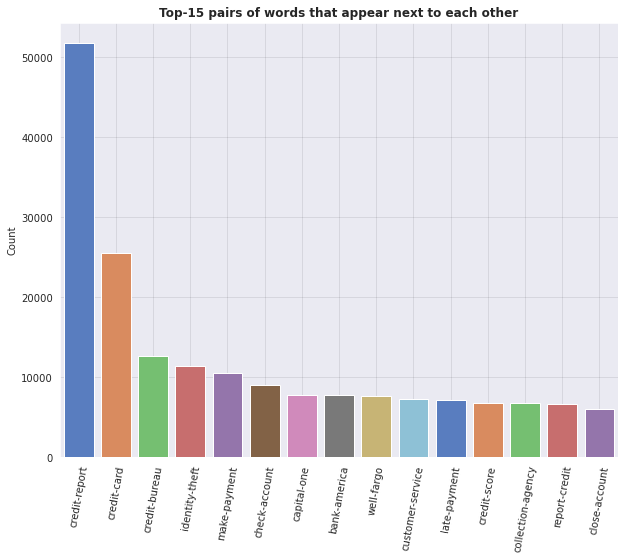

In [62]:
plot_bigrams(input_df=complaints_df, text_col='Complaint_Sentence', top_n=15)

<a id='train_test_sets'> </a>
## Part 4 - Split the data to Train, Test and Validation sets

In [63]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [64]:
label_encoder = LabelEncoder()

complaints_df['Product_Id'] = label_encoder.fit_transform(complaints_df['Product'])

In [65]:
# Categories as a dictionary for reference
product_map = complaints_df.set_index('Product_Id').to_dict()['Product']
dict(sorted(product_map.items()))

{0: 'Checking/savings account',
 1: 'Credit reporting',
 2: 'Credit/prepaid card',
 3: 'Debt collection',
 4: 'Loans',
 5: 'Money services',
 6: 'Mortgage'}

In [66]:
complaints_df.head(5)

,Complaint,Product,Complaint_Tokenized,Complaint_Lemmatized,Complaint_Sentence,Product_Id
0,I contacted Ally on Friday XX/XX/XXXX after fa...,Loans,"[contacted, ally, friday, falling, behind, pay...","[contact, ally, friday, fall, behind, payment,...",contact ally friday fall behind payment due wo...,4
1,I got a loan for {$500.00} in late XXXX with h...,Loans,"[got, loan, 500.00, late, http, owner, let, sp...","[get, loan, 500.00, late, http, owner, let, sp...",get loan 500.00 late http owner let spend 250....,4
2,Two accounts are still on my credit history af...,Credit reporting,"[two, accounts, still, credit, history, contac...","[two, account, still, credit, history, contact...",two account still credit history contact credi...,1
3,I have a bank of America small business credit...,Credit/prepaid card,"[bank, america, small, business, credit, card,...","[bank, america, small, business, credit, card,...",bank america small business credit card reques...,2
4,I opened a citi double cash card the beginning...,Credit/prepaid card,"[opened, citi, double, cash, card, beginning, ...","[open, citi, double, cash, card, begin, still,...",open citi double cash card begin still receive...,2


In [67]:
X = list(complaints_df['Complaint_Lemmatized'])
y = list(complaints_df['Product_Id'])

Split to Train/Test sets:

In [68]:
# Use the stratify parameter in order to split the target variabe (categories) evenly among train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

Further split to Train/Validations sets:

In [69]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify=y_train)

In [70]:
assert len(X_train) + len(X_val) + len(X_test) == len(X)
assert len(y_train) + len(y_val) + len(y_test) == len(y)

In [71]:
len(X_train), len(X_test), len(y_train), len(y_test)

print('The training set has {0} number of complaints.\nThe validation set has {1} number of complaints\nThe test set has {2} number of complaints'.format(len(X_train), len(X_val), len(X_test)))

The training set has 117626 number of complaints.
The validation set has 29407 number of complaints
The test set has 36759 number of complaints


Below we can visualize distribution of categories among the train and test sets where we can observe that both test and training set have similar distribution among the categories, which validates that we have correctly stratified the samples.

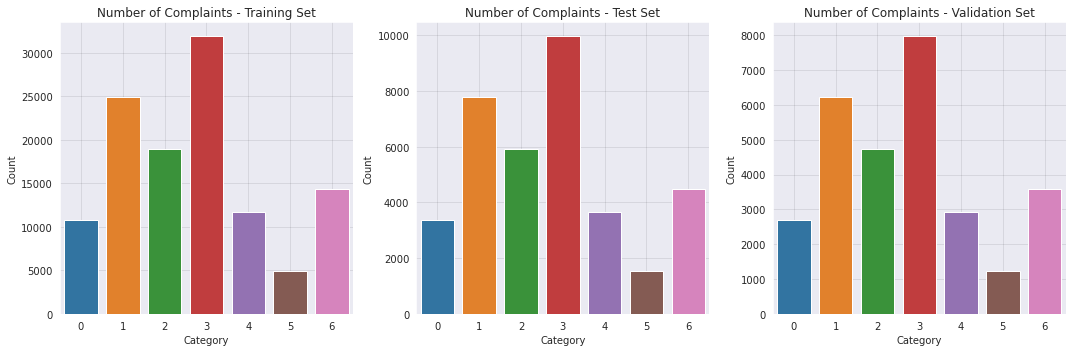

In [72]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(x=sorted(pd.Series(y_train).unique()), y=pd.DataFrame(y_train).groupby(y_train).count().values[:,0], ax=ax1).set_title('Number of Complaints - Training Set')
sns.barplot(x=sorted(pd.Series(y_test).unique()), y=pd.DataFrame(y_test).groupby(y_test).count().values[:,0], ax=ax2).set_title('Number of Complaints - Test Set')
sns.barplot(x=sorted(pd.Series(y_val).unique()), y=pd.DataFrame(y_val).groupby(y_val).count().values[:,0], ax=ax3).set_title('Number of Complaints - Validation Set')
ax1.set_xlabel('Category')
ax1.set_ylabel('Count')
ax1.grid(True, alpha=0.1, color='black')
ax2.set_xlabel('Category')
ax2.set_ylabel('Count')
ax2.grid(True, alpha=0.1, color='black')
ax3.set_xlabel('Category')
ax3.set_ylabel('Count')
ax3.grid(True, alpha=0.1, color='black')
fig.tight_layout()
plt.show()

<a id='model_evaluation_metric'> </a>
## Part 5 - Model Evaluation Metric

Before we move further to the implementation of the actual machine learning algorithms to build the classification models, it's essential to pick an evaluation metric. This metric will be used in a dichotomous way. First, it will help us understand how well an individual algorithm is performing. Secondly, it will assist us during the _comparison_ between different algorithms, in order to decide which one is more accurate at categorizing complaints to their relevant Product category.

In our project, we care about building a model that can categorize each of the complaints accurately, independently of which category it is - in other words, we want to classify as many points accurately as possible despite if they are coming from the majority or minority classes. That said, we would also want to build a robust classifier that is not only good at predicting the major categories, such as 'Deby Collection' and 'Credit Reporting'. Hence, we would want to take into consideration both of this points when deciding regarding the model evaluation metric.

Given that we are interested in building a process where we can assign as many complaints to their correct category as possible, we are proposing the F1-score as the main evaluation metric. Specifically, we will try to optimize and compare the models on the ‘macro’ version of the F1 score, which does not take into consideration the specific weights (i.e. number of instances per class) and thus assigns equal importance to each class. That way we can optimize the algorithms to favour all classes and not the majority ones. 

Specifically, the F1-score can be calculated by following the formula below:

 $Macro \: F_{1}-score=\frac{1}{|T|} \cdot \sum_{t{\in}T}\frac{2 \cdot \text{Precision} \cdot\text{Recall}}{\text{Precision} + \text{Recall}}$

, where T is describing the number of classes/labels.

Except the quantitative evaluation metric above, we will also take into consideration the practical implications of constructing a machine learning algorithm in the business world. Hence, we should also take into account the complexity, as well as the time train/tune each of the models.  These two factors can massively change the decisions that a company might make about which model to productionize, as more complex/time consuming models tend to be a higher cost for them.

Thus, we will also attempt to compare the solutions based on what we believe would be more practical from a business perspective.

<a id='benchmark_model'> </a>
## Part 6 - Implementation of a Benchmark Model with Multinomial Naive Bayes

At this part we are going to define the benchmark model which will be a simple model for classification, and it will be used as a "baseline" for what we define as a success. In other words, we will use this model as the _worst_ case model and then build a more sophisticated model, like XGBoost, with which we will try to outperform the benchmark one . 

For this purpose we are going to construct a Multinomial Naive Bayes Classifier model that will act as the benchmark model.

In [73]:
del complaints_df

In [74]:
data_dir = project_dir / Path(config['input_data']['output_directory'])
data_dir

PosixPath('/home/ec2-user/SageMaker/Capstone/data')

In [75]:
import numpy as np
import joblib

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    max_features=3000,
    preprocessor=lambda x: x,
    tokenizer=lambda x: x,
    analyzer='word',
    ngram_range=(1,1)
)


def extract_bag_of_words_features(vectorizer, x_train, x_test, x_val):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
      
    
    features_train = vectorizer.fit_transform(x_train).toarray()

    features_test = vectorizer.transform(x_test).toarray()
    
    features_val = vectorizer.transform(x_val).toarray()

    return features_train, features_test, features_val

In [76]:
train_X, test_X, val_X = extract_bag_of_words_features(vectorizer, X_train, X_test, X_val)

Save the files locally

In [77]:
# Saving train data
pd.concat([pd.DataFrame(y_train), pd.DataFrame(train_X)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

# Saving validation data
pd.concat([pd.DataFrame(y_val), pd.DataFrame(val_X)], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)

# Saving test data
pd.DataFrame(test_X).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

Now we can start with the model implementation. At first we will need to do some setup like setting up the required AWS roles, bucket, etc , as well as upload our training and test files in the relevant S3 bucket.

In [78]:
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

print("Role: {0}\nBucket: {1}".format(role, bucket))

Role: arn:aws:iam::146083442879:role/service-role/AmazonSageMaker-ExecutionRole-20210930T202561
Bucket: sagemaker-eu-west-2-146083442879


In [79]:
s3_prefix_common = 'capstone-common-data'

In [80]:
train_data_loc_s3 = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=s3_prefix_common)
test_data_loc_s3 = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=s3_prefix_common)
validation_data_loc_s3 = sagemaker_session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=s3_prefix_common)

In [81]:
print(train_data_loc_s3)
print(test_data_loc_s3)
print(validation_data_loc_s3)

s3://sagemaker-eu-west-2-146083442879/capstone-common-data/train.csv
s3://sagemaker-eu-west-2-146083442879/capstone-common-data/test.csv
s3://sagemaker-eu-west-2-146083442879/capstone-common-data/validation.csv


The two paths above contain the final data (train, test) that will be used from the different models that we are going to construct below.

Now we can final start with the implementation of the **benchmark model**, which is going to be a Multinomial Naive Bayes Model.

## Implementation of the Multinomial Naive Bayes model

In [82]:
from sagemaker.sklearn.estimator import SKLearn

s3_prefix_mnb = 'capstone-MNB'

output_path = 's3://{}/{}'.format(bucket, s3_prefix_mnb)
FRAMEWORK_VERSION='0.23-1'

hyper_param_dict = {'alpha': 0.01}

mnb_estimator = SKLearn(
    source_dir='models',
    entry_point='train_mnb_optimized.py',
    role=role,
    framework_version=FRAMEWORK_VERSION,
    py_version='py3',
    instance_count = 1,
    instance_type = 'ml.m5.2xlarge',
    hyperparameters=hyper_param_dict,
    output_path = output_path,
    sagemaker_session = sagemaker_session
)

In [83]:
mnb_estimator.fit({'train': train_data_loc_s3, 'validation': validation_data_loc_s3})

2021-10-21 13:57:28 Starting - Starting the training job...
2021-10-21 13:57:30 Starting - Launching requested ML instancesProfilerReport-1634824648: InProgress
...
2021-10-21 13:58:22 Starting - Preparing the instances for training.........
2021-10-21 13:59:55 Downloading - Downloading input data
2021-10-21 13:59:55 Training - Downloading the training image...
2021-10-21 14:00:15 Training - Training image download completed. Training in progress.2021-10-21 14:00:15,436 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-10-21 14:00:15,438 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-10-21 14:00:15,448 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-10-21 14:00:15,697 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-10-21 14:00:18,748 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-10-21 14:00:

In [84]:
mnb_transformer = mnb_estimator.transformer(
    instance_count = 1,
    instance_type = 'ml.m5.2xlarge',
    max_payload=20
)

In [85]:
print('Test input retrieved from .. {0}'.format(test_data_loc_s3))

Test input retrieved from .. s3://sagemaker-eu-west-2-146083442879/capstone-common-data/test.csv


In [86]:
mnb_transformer.transform(test_data_loc_s3, content_type='text/csv', split_type='Line')

..........................2021-10-21 14:15:05,588 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2021-10-21 14:15:05,591 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2021-10-21 14:15:05,591 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
2021-10-21 14:15:05,588 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2021-10-21 14:15:05,591 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2021-10-21 14:15:05,591 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_bod

169.254.255.130 - - [21/Oct/2021:14:15:28 +0000] "POST /invocations HTTP/1.1" 200 10485 "-" "Go-http-client/1.1"
169.254.255.130 - - [21/Oct/2021:14:15:28 +0000] "POST /invocations HTTP/1.1" 200 10485 "-" "Go-http-client/1.1"
169.254.255.130 - - [21/Oct/2021:14:15:32 +0000] "POST /invocations HTTP/1.1" 200 10485 "-" "Go-http-client/1.1"
169.254.255.130 - - [21/Oct/2021:14:15:32 +0000] "POST /invocations HTTP/1.1" 200 10485 "-" "Go-http-client/1.1"
169.254.255.130 - - [21/Oct/2021:14:15:40 +0000] "POST /invocations HTTP/1.1" 200 10485 "-" "Go-http-client/1.1"
169.254.255.130 - - [21/Oct/2021:14:15:40 +0000] "POST /invocations HTTP/1.1" 200 10485 "-" "Go-http-client/1.1"
2021-10-21 14:15:45,150 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2021-10-21 14:15:45,150 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
Loading model.
Done loading model.
Loading model.
Done loading model.
169.254.255.130 - - [21/Oct/2021:14:15:49 +0000] "

In [87]:
!aws s3 cp --recursive $mnb_transformer.output_path $data_dir/mnb_output

download: s3://sagemaker-eu-west-2-146083442879/sagemaker-scikit-learn-2021-10-21-14-10-51-771/test.csv.out to data/mnb_output/test.csv.out


In [138]:
mnb_y_pred = pd.read_csv(os.path.join(data_dir, 'mnb_output', 'test.csv.out'), header=None)

Note that the element returned from the process above (i.e. the predictions) are in a string format. Hence, its necessary to build a custom function to format the data into a format the we can easily work with. Thus, we are constructing the function below which accepts as input the predictions as received from the AWS output, and produces a list of integers that contains the predictions:

In [139]:
from typing import List

def clean_predictions(preds: pd.DataFrame) -> List[int]:
    predictions = []
    for elemement in preds:
        if type(elemement) == str:
            elemement = elemement.strip()
            if elemement.startswith('['):
                predictions.append(int(elemement[1]))
            elif elemement.endswith(']'):
                predictions.append(int(elemement[0]))
            elif '][' in elemement:
                for num in elemement.split(']['):
                    predictions.append(int(num.strip())) 
        elif type(elemement) == int:
            predictions.append(elemement)
    return predictions

In [140]:
mnb_y_pred = clean_predictions(mnb_y_pred.values[0])

In [141]:
assert len(mnb_y_pred) == len(y_test)

In [142]:
from sklearn import metrics

metrics.accuracy_score(y_test, mnb_y_pred)
print(metrics.classification_report(y_test, mnb_y_pred))
print(metrics.f1_score(y_test, mnb_y_pred, average='macro'))

              precision    recall  f1-score   support

           0       0.73      0.74      0.73      3377
           1       0.75      0.78      0.77      7802
           2       0.78      0.76      0.77      5927
           3       0.85      0.74      0.79      9967
           4       0.68      0.77      0.72      3653
           5       0.60      0.76      0.67      1533
           6       0.87      0.91      0.89      4500

    accuracy                           0.78     36759
   macro avg       0.75      0.78      0.76     36759
weighted avg       0.78      0.78      0.78     36759

0.7635954093849946


In [143]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plotConfusionMatrixHeatmap(input_df: pd.DataFrame, model_name: str, figsize=(20, 18)):
    """
    Return the results of a multiclass classification algorithms as a heatmap
    based on a confusion matrix.        
    """
    # Heatmap of the results
    plt.figure(figsize=figsize)
    sns.heatmap(input_df, annot=True, fmt='d', cmap='Reds')
    plt.ylabel('True', fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold')
    plt.title(f'Heatmap - {model_name}', size=14, fontweight='bold')
    plt.show()

In [144]:
key_to_product_names = [x[1] for x in sorted(product_map.items())]
key_to_product_names

['Checking/savings account',
 'Credit reporting',
 'Credit/prepaid card',
 'Debt collection',
 'Loans',
 'Money services',
 'Mortgage']

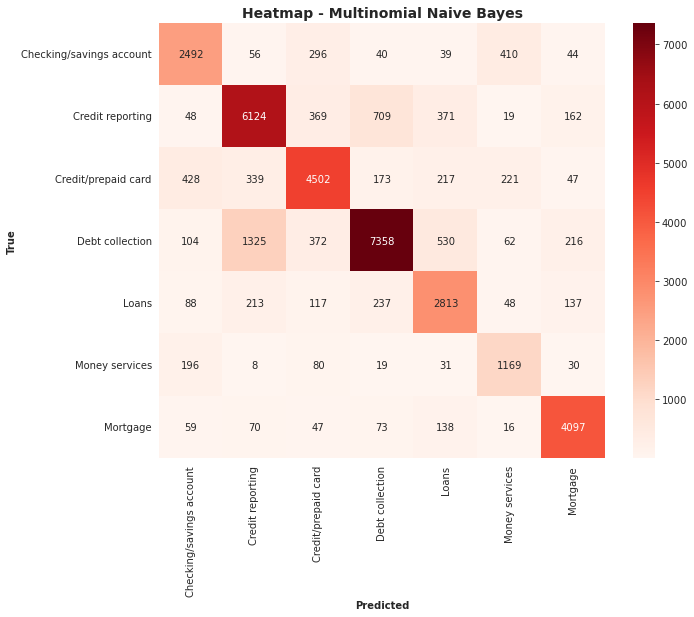

In [145]:
conf_matrix_mnb_df = pd.DataFrame(data=confusion_matrix(y_test, mnb_y_pred),index=key_to_product_names, columns=key_to_product_names)

plotConfusionMatrixHeatmap(conf_matrix_mnb_df, model_name='Multinomial Naive Bayes', figsize=(10, 8))

## Implementation of the **XGBoost** model

In [114]:
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput

s3_prefix_xgb = 'capstone-xgboost'
prefix_xgb = 'xgb_model'

output_path = 's3://{}/{}'.format(bucket, s3_prefix_xgb)

In [115]:
xgb_container = image_uris.retrieve(
    framework='xgboost',
    region=sagemaker_session.boto_region_name,
    version="1.2-2"
)

In [116]:
xgb = sagemaker.estimator.Estimator(
    image_uri=xgb_container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix_xgb),
    sagemaker_session=sagemaker_session
)

In [117]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        num_class=7,
                        objective="multi:softmax",
                        early_stopping_rounds=10,
                        num_round=100)

In [118]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, 
                                               objective_metric_name = 'validation:f1', 
                                               objective_type = 'Maximize', 
                                               max_jobs = 15, 
                                               max_parallel_jobs = 3, 
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(60, 200),
                                                    'eta'      : ContinuousParameter(0.2, 0.8),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(4, 8)
                                               })

In [119]:
s3_input_train = TrainingInput(s3_data=train_data_loc_s3, content_type='csv')
s3_input_validation = TrainingInput(s3_data=validation_data_loc_s3, content_type='csv')

In [ ]:
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [122]:
xgb_hyperparameter_tuner.best_training_job()

'sagemaker-xgboost-211021-1424-020-d4215ce1'

In [123]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())


2021-10-21 19:39:22 Starting - Preparing the instances for training
2021-10-21 19:39:22 Downloading - Downloading input data
2021-10-21 19:39:22 Training - Training image download completed. Training in progress.
2021-10-21 19:39:22 Uploading - Uploading generated training model
2021-10-21 19:39:22 Completed - Training job completed


In [124]:
xgb_transformer = xgb_attached.transformer(
    instance_count = 1,
    instance_type = 'ml.m5.2xlarge',
    max_payload=1
)

In [125]:
xgb_transformer.transform(test_data_loc_s3, content_type='text/csv', split_type='Line')

............................2021-10-21T20:05:58.892:[sagemaker logs]: MaxConcurrentTransforms=8, MaxPayloadInMB=1, BatchStrategy=MULTI_RECORD
[2021-10-21:20:05:54:INFO] No GPUs detected (normal if no gpus installed)
[2021-10-21:20:05:54:INFO] No GPUs detected (normal if no gpus installed)
[2021-10-21:20:05:54:INFO] nginx config: 
[2021-10-21:20:05:54:INFO] No GPUs detected (normal if no gpus installed)
[2021-10-21:20:05:54:INFO] No GPUs detected (normal if no gpus installed)
[2021-10-21:20:05:54:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
 

169.254.255.130 - - [21/Oct/2021:20:06:14 +0000] "POST /invocations HTTP/1.1" 200 696 "-" "Go-http-client/1.1"
169.254.255.130 - - [21/Oct/2021:20:06:14 +0000] "POST /invocations HTTP/1.1" 200 696 "-" "Go-http-client/1.1"
[2021-10-21:20:06:14:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [21/Oct/2021:20:06:14 +0000] "POST /invocations HTTP/1.1" 200 696 "-" "Go-http-client/1.1"
169.254.255.130 - - [21/Oct/2021:20:06:14 +0000] "POST /invocations HTTP/1.1" 200 696 "-" "Go-http-client/1.1"
169.254.255.130 - - [21/Oct/2021:20:06:14 +0000] "POST /invocations HTTP/1.1" 200 180 "-" "Go-http-client/1.1"
169.254.255.130 - - [21/Oct/2021:20:06:14 +0000] "POST /invocations HTTP/1.1" 200 696 "-" "Go-http-client/1.1"
169.254.255.130 - - [21/Oct/2021:20:06:14 +0000] "POST /invocations HTTP/1.1" 200 696 "-" "Go-http-client/1.1"
[2021-10-21:20:06:14:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [21/Oct/2021:20:06:14 +0000] "POST /invocations HTTP/1.1" 200 696 "

In [127]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir/xgboost_output

download: s3://sagemaker-eu-west-2-146083442879/sagemaker-xgboost-2021-10-21-20-01-22-421/test.csv.out to data/xgboost_output/test.csv.out


In [128]:
xgb_y_pred = pd.read_csv(os.path.join(data_dir, 'xgboost_output', 'test.csv.out'), header=None)

In [129]:
xgb_y_pred.values

array([[4.],
       [2.],
       [4.],
       ...,
       [1.],
       [3.],
       [3.]])

In [130]:
from sklearn import metrics

print(metrics.classification_report(y_test, xgb_y_pred.values))
print(metrics.f1_score(y_test, xgb_y_pred.values, average='macro'))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      3377
           1       0.79      0.78      0.78      7802
           2       0.75      0.78      0.76      5927
           3       0.79      0.81      0.80      9967
           4       0.70      0.70      0.70      3653
           5       0.70      0.55      0.62      1533
           6       0.88      0.86      0.87      4500

    accuracy                           0.77     36759
   macro avg       0.76      0.74      0.75     36759
weighted avg       0.77      0.77      0.77     36759

0.7492027174197295


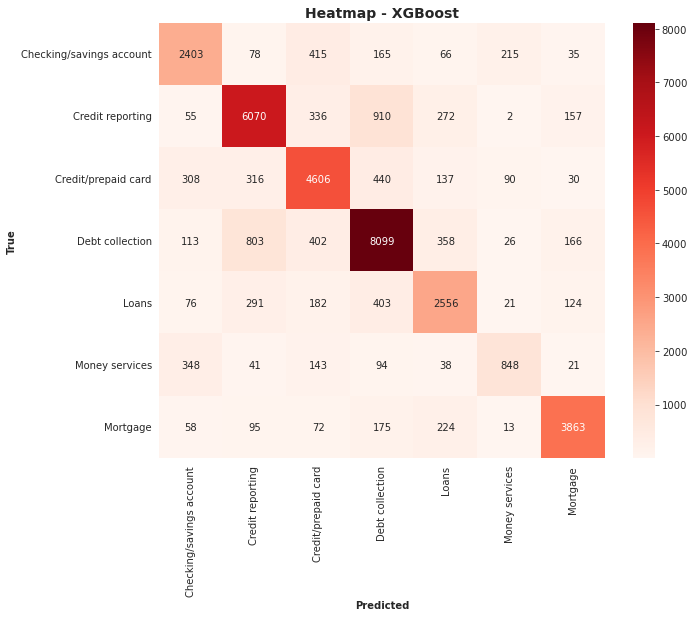

In [137]:
conf_matrix_xgb_df = pd.DataFrame(data=confusion_matrix(y_test, xgb_y_pred),index=key_to_product_names, columns=key_to_product_names)

plotConfusionMatrixHeatmap(conf_matrix_xgb_df, model_name='XGBoost', figsize=(10, 8))